In [1]:
import pickle
import pandas as pd
import numpy as np
import gc; gc.enable()
import lightgbm as lgb

In [2]:
with open('data/active_test_train.pickle', 'rb') as handle:
    test_train = pickle.load(handle)
    
with open('data/active_test_test.pickle', 'rb') as handle:
    test_test = pickle.load(handle)
    
with open('data/active_train.pickle', 'rb') as handle:
    train = pickle.load(handle)

In [3]:
test_train_len = test_train.shape[0]

test = pd.concat([test_train, test_test]).reset_index(drop=True)
del test_train, test_test; gc.collect()

0

In [4]:
import pandas as pd
import numpy as np
import gc; gc.enable()
import lightgbm as lgb
import warnings 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
    
from GridSearcher import data_loader, model_loader, fit_params, get_oof_predictions
from tqdm import tqdm

In [5]:
def rmse(truth, pred):
    return mean_squared_error(truth, pred)**.5

In [6]:
ml = model_loader(model_type='lgb')

In [7]:
def plot_oof_model_importances(models):
    for model in models:
        fig, ax = plt.subplots(figsize=(10, 14))
        lgb.plot_importance(model, max_num_features=80, ax=ax)
        plt.title("Light GBM Feature Importance")
        plt.show()

In [8]:
dp_y = pd.read_csv('regression_target.csv').deal_probability.values

## Train price

In [9]:
SEED=987
categorical = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3']
features = categorical + \
    ['item_seq_number', 'title_len', 'title_word_cnt', 'title_unique_word_cnt', 'title_unqiue_percent', 
     'description_len', 'description_word_cnt', 'description_unique_word_cnt', 'description_unqiue_percent']
target = 'price'

In [10]:
tr_filter = train.price >= 0

In [11]:
y = np.log1p(train.loc[tr_filter, target].values)
X = train.loc[tr_filter, features].reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)

In [12]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':256, 
    'max_depth':15, 
    'learning_rate':0.1, 
    'n_estimators':50000, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':1.,
    'subsample_freq':1, 
    'colsample_bytree':1., 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':SEED, 
    'n_jobs': 3
}

fit_param = {
    'feature_name': features, 
    'categorical_feature': categorical,
    'early_stopping_rounds': 50,
    'verbose': 100,
    'eval_metric': 'rmse'
}

model= ml.load(default_params)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          eval_names=['train', 'valid'], 
          **fit_param)

lgb_oof_test_pred = np.expm1(model.predict(test[features]))

Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 1.72222	valid's rmse: 1.73195
[200]	train's rmse: 1.703	valid's rmse: 1.71972
[300]	train's rmse: 1.69069	valid's rmse: 1.71235
[400]	train's rmse: 1.68053	valid's rmse: 1.70632
[500]	train's rmse: 1.67284	valid's rmse: 1.70213
[600]	train's rmse: 1.66687	valid's rmse: 1.69894
[700]	train's rmse: 1.66145	valid's rmse: 1.69612
[800]	train's rmse: 1.65582	valid's rmse: 1.69327
[900]	train's rmse: 1.65018	valid's rmse: 1.69045
[1000]	train's rmse: 1.6449	valid's rmse: 1.68786
[1100]	train's rmse: 1.63995	valid's rmse: 1.68527
[1200]	train's rmse: 1.63517	valid's rmse: 1.68275
[1300]	train's rmse: 1.6304	valid's rmse: 1.68039
[1400]	train's rmse: 1.62503	valid's rmse: 1.67769
[1500]	train's rmse: 1.62053	valid's rmse: 1.6756
[1600]	train's rmse: 1.61595	valid's rmse: 1.67343
[1700]	train's rmse: 1.61124	valid's rmse: 1.67112
[1800]	train's rmse: 1.60742	valid's rmse: 1.66924
[1900]	train's rmse: 1.60339	valid

[16000]	train's rmse: 1.34186	valid's rmse: 1.54736
[16100]	train's rmse: 1.34066	valid's rmse: 1.54681
[16200]	train's rmse: 1.33943	valid's rmse: 1.54625
[16300]	train's rmse: 1.33813	valid's rmse: 1.54569
[16400]	train's rmse: 1.33702	valid's rmse: 1.54519
[16500]	train's rmse: 1.33582	valid's rmse: 1.54465
[16600]	train's rmse: 1.33465	valid's rmse: 1.54412
[16700]	train's rmse: 1.33353	valid's rmse: 1.5436
[16800]	train's rmse: 1.33234	valid's rmse: 1.54307
[16900]	train's rmse: 1.33111	valid's rmse: 1.54252
[17000]	train's rmse: 1.32995	valid's rmse: 1.542
[17100]	train's rmse: 1.32897	valid's rmse: 1.54156
[17200]	train's rmse: 1.32778	valid's rmse: 1.54105
[17300]	train's rmse: 1.32658	valid's rmse: 1.54053
[17400]	train's rmse: 1.32546	valid's rmse: 1.54003
[17500]	train's rmse: 1.32441	valid's rmse: 1.53955
[17600]	train's rmse: 1.32309	valid's rmse: 1.53899
[17700]	train's rmse: 1.32207	valid's rmse: 1.53854
[17800]	train's rmse: 1.32115	valid's rmse: 1.53813
[17900]	train's

[31800]	train's rmse: 1.1924	valid's rmse: 1.48095
[31900]	train's rmse: 1.19168	valid's rmse: 1.48064
[32000]	train's rmse: 1.19097	valid's rmse: 1.48033
[32100]	train's rmse: 1.19021	valid's rmse: 1.48002
[32200]	train's rmse: 1.18941	valid's rmse: 1.47967
[32300]	train's rmse: 1.18872	valid's rmse: 1.47939
[32400]	train's rmse: 1.18795	valid's rmse: 1.47906
[32500]	train's rmse: 1.18712	valid's rmse: 1.4787
[32600]	train's rmse: 1.18624	valid's rmse: 1.47834
[32700]	train's rmse: 1.18555	valid's rmse: 1.47803
[32800]	train's rmse: 1.18492	valid's rmse: 1.47775
[32900]	train's rmse: 1.18419	valid's rmse: 1.47742
[33000]	train's rmse: 1.18329	valid's rmse: 1.47703
[33100]	train's rmse: 1.18268	valid's rmse: 1.47675
[33200]	train's rmse: 1.18197	valid's rmse: 1.47643
[33300]	train's rmse: 1.18123	valid's rmse: 1.4761
[33400]	train's rmse: 1.18045	valid's rmse: 1.47575
[33500]	train's rmse: 1.17956	valid's rmse: 1.47535
[33600]	train's rmse: 1.17881	valid's rmse: 1.47502
[33700]	train's

[47600]	train's rmse: 1.08404	valid's rmse: 1.43478
[47700]	train's rmse: 1.08345	valid's rmse: 1.43453
[47800]	train's rmse: 1.08289	valid's rmse: 1.43429
[47900]	train's rmse: 1.0823	valid's rmse: 1.43405
[48000]	train's rmse: 1.08176	valid's rmse: 1.43382
[48100]	train's rmse: 1.08125	valid's rmse: 1.43363
[48200]	train's rmse: 1.0808	valid's rmse: 1.43342
[48300]	train's rmse: 1.08026	valid's rmse: 1.43318
[48400]	train's rmse: 1.07972	valid's rmse: 1.43294
[48500]	train's rmse: 1.07912	valid's rmse: 1.43269
[48600]	train's rmse: 1.07861	valid's rmse: 1.43246
[48700]	train's rmse: 1.07807	valid's rmse: 1.43222
[48800]	train's rmse: 1.07764	valid's rmse: 1.43203
[48900]	train's rmse: 1.07708	valid's rmse: 1.43179
[49000]	train's rmse: 1.07648	valid's rmse: 1.43154
[49100]	train's rmse: 1.07595	valid's rmse: 1.43133
[49200]	train's rmse: 1.07549	valid's rmse: 1.43115
[49300]	train's rmse: 1.07481	valid's rmse: 1.43088
[49400]	train's rmse: 1.07426	valid's rmse: 1.43064
[49500]	train'

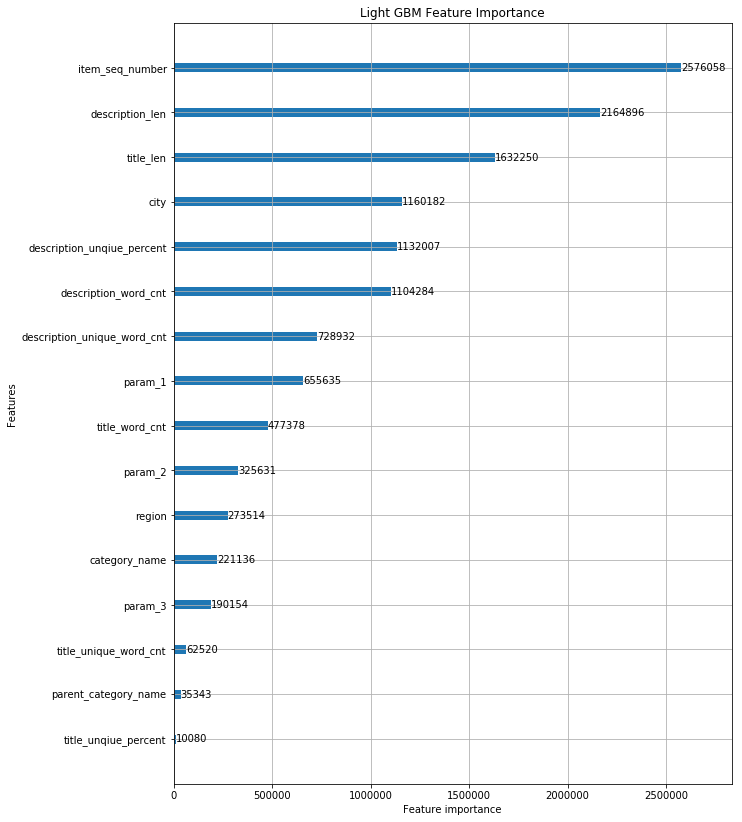

In [14]:
plot_oof_model_importances([model])

In [15]:
pd.DataFrame(data=lgb_oof_test_pred[:test_train_len], columns=['active_price_pred']).to_csv('train_active_price_pred.csv', index=False)
pd.DataFrame(data=lgb_oof_test_pred[test_train_len:], columns=['active_price_pred']).to_csv('test_active_price_pred.csv', index=False)

In [18]:
df = pd.DataFrame(data=lgb_oof_test_pred[:test_train_len], columns=['pred'])
df['deal_prob'] = dp_y
df.corr()

,pred,deal_prob
pred,1.000000,-0.015015
deal_prob,-0.015015,1.000000


## Train duration

In [9]:
SEED=789
categorical = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3']
features = categorical + \
    ['item_seq_number', 'title_len', 'title_word_cnt', 'title_unique_word_cnt', 'title_unqiue_percent', 
     'description_len', 'description_word_cnt', 'description_unique_word_cnt', 'description_unqiue_percent', 'price']
target = 'days_up'

In [10]:
y = train.loc[:, target].values
X = train.loc[:, features].reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)

In [11]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':256, 
    'max_depth':15, 
    'learning_rate':0.3, 
    'n_estimators':50000, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':1.,
    'subsample_freq':1, 
    'colsample_bytree':1., 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':SEED, 
    'n_jobs': 3
}

fit_param = {
    'feature_name': features, 
    'categorical_feature': categorical,
    'early_stopping_rounds': 50,
    'verbose': 100,
    'eval_metric': 'rmse'
}

model= ml.load(default_params)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          eval_names=['train', 'valid'], 
          **fit_param)

lgb_oof_test_pred = model.predict(test[features])

Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 4.93928	valid's rmse: 4.97698
[200]	train's rmse: 4.91015	valid's rmse: 4.96556
[300]	train's rmse: 4.88988	valid's rmse: 4.95831
[400]	train's rmse: 4.87158	valid's rmse: 4.95155
[500]	train's rmse: 4.8561	valid's rmse: 4.94663
[600]	train's rmse: 4.83971	valid's rmse: 4.94129
[700]	train's rmse: 4.82433	valid's rmse: 4.9361
[800]	train's rmse: 4.80966	valid's rmse: 4.93104
[900]	train's rmse: 4.79732	valid's rmse: 4.927
[1000]	train's rmse: 4.78503	valid's rmse: 4.92322
[1100]	train's rmse: 4.7734	valid's rmse: 4.91952
[1200]	train's rmse: 4.76177	valid's rmse: 4.91584
[1300]	train's rmse: 4.75037	valid's rmse: 4.91223
[1400]	train's rmse: 4.73945	valid's rmse: 4.90902
[1500]	train's rmse: 4.72809	valid's rmse: 4.90543
[1600]	train's rmse: 4.71795	valid's rmse: 4.90245
[1700]	train's rmse: 4.70757	valid's rmse: 4.89931
[1800]	train's rmse: 4.69694	valid's rmse: 4.8963
[1900]	train's rmse: 4.68715	valid'

[16000]	train's rmse: 3.8767	valid's rmse: 4.67735
[16100]	train's rmse: 3.87251	valid's rmse: 4.67618
[16200]	train's rmse: 3.86849	valid's rmse: 4.67516
[16300]	train's rmse: 3.86421	valid's rmse: 4.67414
[16400]	train's rmse: 3.86029	valid's rmse: 4.67308
[16500]	train's rmse: 3.85589	valid's rmse: 4.67196
[16600]	train's rmse: 3.85112	valid's rmse: 4.67082
[16700]	train's rmse: 3.846	valid's rmse: 4.66955
[16800]	train's rmse: 3.84186	valid's rmse: 4.6685
[16900]	train's rmse: 3.83748	valid's rmse: 4.6674
[17000]	train's rmse: 3.83336	valid's rmse: 4.66641
[17100]	train's rmse: 3.82929	valid's rmse: 4.66534
[17200]	train's rmse: 3.82472	valid's rmse: 4.66415
[17300]	train's rmse: 3.82042	valid's rmse: 4.66304
[17400]	train's rmse: 3.81673	valid's rmse: 4.66211
[17500]	train's rmse: 3.81247	valid's rmse: 4.66114
[17600]	train's rmse: 3.80818	valid's rmse: 4.66014
[17700]	train's rmse: 3.80387	valid's rmse: 4.65904
[17800]	train's rmse: 3.79925	valid's rmse: 4.6579
[17900]	train's rm

[31800]	train's rmse: 3.31686	valid's rmse: 4.53923
[31900]	train's rmse: 3.31365	valid's rmse: 4.53849
[32000]	train's rmse: 3.31071	valid's rmse: 4.5378
[32100]	train's rmse: 3.30748	valid's rmse: 4.5371
[32200]	train's rmse: 3.30428	valid's rmse: 4.53642
[32300]	train's rmse: 3.30088	valid's rmse: 4.53555
[32400]	train's rmse: 3.29772	valid's rmse: 4.53477
[32500]	train's rmse: 3.29424	valid's rmse: 4.53396
[32600]	train's rmse: 3.29158	valid's rmse: 4.53323
[32700]	train's rmse: 3.28829	valid's rmse: 4.53242
[32800]	train's rmse: 3.28539	valid's rmse: 4.53177
[32900]	train's rmse: 3.28214	valid's rmse: 4.53103
[33000]	train's rmse: 3.27869	valid's rmse: 4.53019
[33100]	train's rmse: 3.27551	valid's rmse: 4.52946
[33200]	train's rmse: 3.27206	valid's rmse: 4.52864
[33300]	train's rmse: 3.26887	valid's rmse: 4.52788
[33400]	train's rmse: 3.26564	valid's rmse: 4.52722
[33500]	train's rmse: 3.26266	valid's rmse: 4.52659
[33600]	train's rmse: 3.26005	valid's rmse: 4.52597
[33700]	train'

[47600]	train's rmse: 2.88224	valid's rmse: 4.43733
[47700]	train's rmse: 2.87988	valid's rmse: 4.43677
[47800]	train's rmse: 2.87704	valid's rmse: 4.43609
[47900]	train's rmse: 2.87431	valid's rmse: 4.43547
[48000]	train's rmse: 2.87175	valid's rmse: 4.43486
[48100]	train's rmse: 2.86958	valid's rmse: 4.43434
[48200]	train's rmse: 2.86663	valid's rmse: 4.43373
[48300]	train's rmse: 2.8638	valid's rmse: 4.43314
[48400]	train's rmse: 2.86167	valid's rmse: 4.43266
[48500]	train's rmse: 2.85958	valid's rmse: 4.43215
[48600]	train's rmse: 2.85654	valid's rmse: 4.43147
[48700]	train's rmse: 2.85454	valid's rmse: 4.43096
[48800]	train's rmse: 2.85247	valid's rmse: 4.43046
[48900]	train's rmse: 2.85008	valid's rmse: 4.42986
[49000]	train's rmse: 2.84713	valid's rmse: 4.42927
[49100]	train's rmse: 2.84468	valid's rmse: 4.42868
[49200]	train's rmse: 2.84191	valid's rmse: 4.42808
[49300]	train's rmse: 2.83962	valid's rmse: 4.42755
[49400]	train's rmse: 2.83696	valid's rmse: 4.42691
[49500]	train

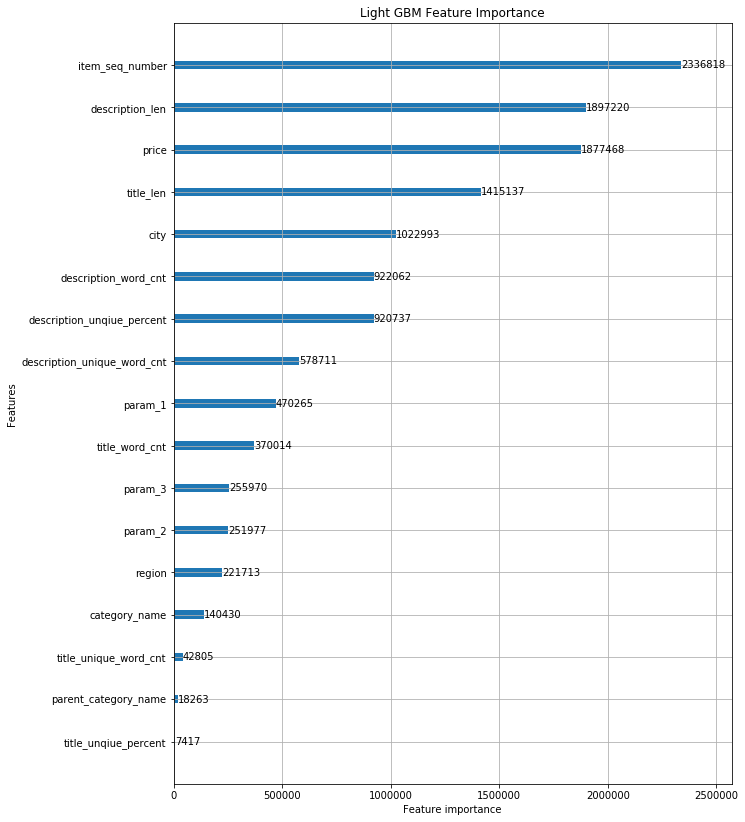

In [12]:
plot_oof_model_importances([model])

In [13]:
pd.DataFrame(data=lgb_oof_test_pred[:test_train_len], columns=['active_duration_pred']).to_csv('train_active_duration_pred.csv', index=False)
pd.DataFrame(data=lgb_oof_test_pred[test_train_len:], columns=['active_duration_pred']).to_csv('test_active_duration_pred.csv', index=False)

In [14]:
df = pd.DataFrame(data=lgb_oof_test_pred[:test_train_len], columns=['pred'])
df['deal_prob'] = dp_y
df.corr()

,pred,deal_prob
pred,1.000000,-0.192982
deal_prob,-0.192982,1.000000


## Train ad count pred

In [9]:
SEED=648
categorical = ['region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3']
features = categorical + \
    ['item_seq_number', 'title_len', 'title_word_cnt', 'title_unique_word_cnt', 'title_unqiue_percent', 
     'description_len', 'description_word_cnt', 'description_unique_word_cnt', 'description_unqiue_percent', 'price']
target = 'ad_total_count'

In [10]:
y = train.loc[:, target].values
X = train.loc[:, features].reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=123)

In [11]:
default_params = {
    'boosting_type':'gbdt', 
    'num_leaves':256, 
    'max_depth':15, 
    'learning_rate':0.3, 
    'n_estimators':50000, 
    'min_split_gain':0.0, 
    'min_child_weight':0.001, 
    'min_child_samples':20, 
    'subsample':1.,
    'subsample_freq':1, 
    'colsample_bytree':1., 
    'reg_alpha':0.0, 
    'reg_lambda':0.0, 
    'random_state':SEED, 
    'n_jobs': 3
}

fit_param = {
    'feature_name': features, 
    'categorical_feature': categorical,
    'early_stopping_rounds': 50,
    'verbose': 100,
    'eval_metric': 'rmse'
}

model= ml.load(default_params)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          eval_names=['train', 'valid'], 
          **fit_param)

lgb_oof_test_pred = model.predict(test[features])

Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.765242	valid's rmse: 0.770024
[200]	train's rmse: 0.760846	valid's rmse: 0.767975
[300]	train's rmse: 0.757634	valid's rmse: 0.766602
[400]	train's rmse: 0.754644	valid's rmse: 0.765197
[500]	train's rmse: 0.752029	valid's rmse: 0.764077
[600]	train's rmse: 0.749727	valid's rmse: 0.763118
[700]	train's rmse: 0.747453	valid's rmse: 0.762196
[800]	train's rmse: 0.745288	valid's rmse: 0.761379
[900]	train's rmse: 0.74323	valid's rmse: 0.760562
[1000]	train's rmse: 0.740941	valid's rmse: 0.759571
[1100]	train's rmse: 0.739149	valid's rmse: 0.758858
[1200]	train's rmse: 0.737443	valid's rmse: 0.758193
[1300]	train's rmse: 0.735675	valid's rmse: 0.757523
[1400]	train's rmse: 0.734032	valid's rmse: 0.756903
[1500]	train's rmse: 0.732452	valid's rmse: 0.75631
[1600]	train's rmse: 0.730862	valid's rmse: 0.755731
[1700]	train's rmse: 0.729233	valid's rmse: 0.755076
[1800]	train's rmse: 0.727605	valid's rmse: 0.75

[15400]	train's rmse: 0.59827	valid's rmse: 0.707769
[15500]	train's rmse: 0.597567	valid's rmse: 0.707529
[15600]	train's rmse: 0.596977	valid's rmse: 0.707313
[15700]	train's rmse: 0.59624	valid's rmse: 0.707053
[15800]	train's rmse: 0.595491	valid's rmse: 0.706785
[15900]	train's rmse: 0.594777	valid's rmse: 0.706525
[16000]	train's rmse: 0.594077	valid's rmse: 0.706264
[16100]	train's rmse: 0.593448	valid's rmse: 0.706039
[16200]	train's rmse: 0.592626	valid's rmse: 0.705762
[16300]	train's rmse: 0.591929	valid's rmse: 0.705506
[16400]	train's rmse: 0.59113	valid's rmse: 0.705222
[16500]	train's rmse: 0.590408	valid's rmse: 0.704966
[16600]	train's rmse: 0.58972	valid's rmse: 0.70472
[16700]	train's rmse: 0.588989	valid's rmse: 0.704463
[16800]	train's rmse: 0.588292	valid's rmse: 0.704219
[16900]	train's rmse: 0.58763	valid's rmse: 0.703972
[17000]	train's rmse: 0.586664	valid's rmse: 0.703651
[17100]	train's rmse: 0.585926	valid's rmse: 0.703395
[17200]	train's rmse: 0.585212	val

[30600]	train's rmse: 0.508195	valid's rmse: 0.676356
[30700]	train's rmse: 0.507573	valid's rmse: 0.676143
[30800]	train's rmse: 0.507094	valid's rmse: 0.675984
[30900]	train's rmse: 0.506538	valid's rmse: 0.675782
[31000]	train's rmse: 0.505977	valid's rmse: 0.675597
[31100]	train's rmse: 0.505522	valid's rmse: 0.675433
[31200]	train's rmse: 0.504993	valid's rmse: 0.675251
[31300]	train's rmse: 0.504442	valid's rmse: 0.675063
[31400]	train's rmse: 0.503879	valid's rmse: 0.674872
[31500]	train's rmse: 0.503416	valid's rmse: 0.674708
[31600]	train's rmse: 0.502988	valid's rmse: 0.674546
[31700]	train's rmse: 0.502456	valid's rmse: 0.674362
[31800]	train's rmse: 0.50207	valid's rmse: 0.674225
[31900]	train's rmse: 0.501461	valid's rmse: 0.674015
[32000]	train's rmse: 0.500951	valid's rmse: 0.673832
[32100]	train's rmse: 0.500407	valid's rmse: 0.67365
[32200]	train's rmse: 0.499925	valid's rmse: 0.673465
[32300]	train's rmse: 0.499334	valid's rmse: 0.673271
[32400]	train's rmse: 0.498869

[45800]	train's rmse: 0.439316	valid's rmse: 0.652761
[45900]	train's rmse: 0.438883	valid's rmse: 0.652614
[46000]	train's rmse: 0.438369	valid's rmse: 0.652441
[46100]	train's rmse: 0.438001	valid's rmse: 0.652314
[46200]	train's rmse: 0.437641	valid's rmse: 0.652186
[46300]	train's rmse: 0.437277	valid's rmse: 0.652053
[46400]	train's rmse: 0.436935	valid's rmse: 0.651938
[46500]	train's rmse: 0.436589	valid's rmse: 0.651815
[46600]	train's rmse: 0.43612	valid's rmse: 0.651663
[46700]	train's rmse: 0.435801	valid's rmse: 0.651543
[46800]	train's rmse: 0.435434	valid's rmse: 0.65142
[46900]	train's rmse: 0.434952	valid's rmse: 0.651275
[47000]	train's rmse: 0.434551	valid's rmse: 0.651137
[47100]	train's rmse: 0.434179	valid's rmse: 0.651007
[47200]	train's rmse: 0.433897	valid's rmse: 0.65091
[47300]	train's rmse: 0.433562	valid's rmse: 0.650797
[47400]	train's rmse: 0.433129	valid's rmse: 0.650658
[47500]	train's rmse: 0.432592	valid's rmse: 0.650476
[47600]	train's rmse: 0.432229	

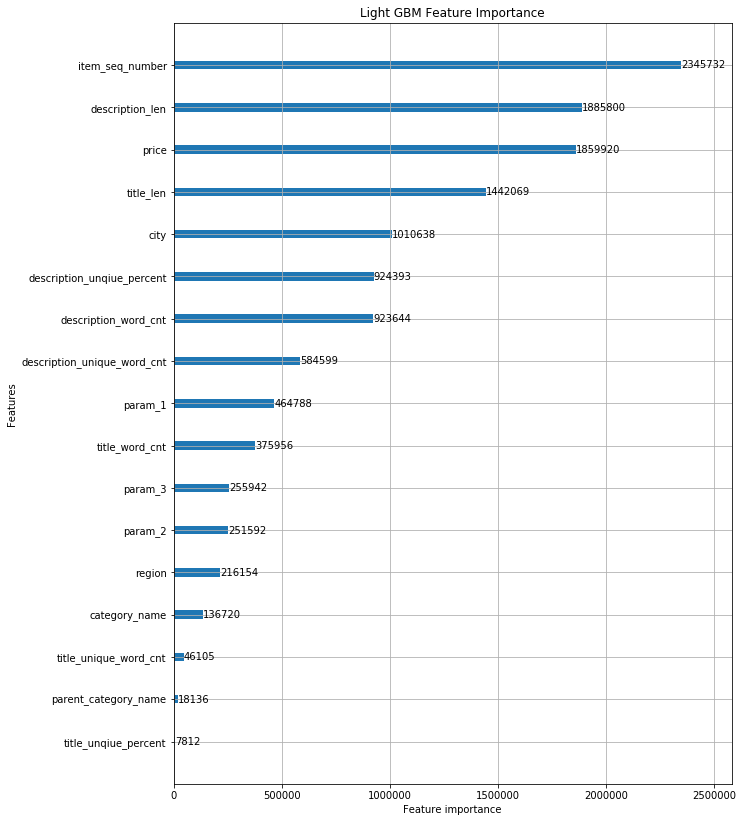

In [14]:
plot_oof_model_importances([model])

In [15]:
pd.DataFrame(data=lgb_oof_test_pred[:test_train_len], columns=['active_ad_count_pred']).to_csv('train_active_ad_count_pred.csv', index=False)
pd.DataFrame(data=lgb_oof_test_pred[test_train_len:], columns=['active_ad_count_pred']).to_csv('test_active_ad_count_pred.csv', index=False)

In [16]:
df = pd.DataFrame(data=lgb_oof_test_pred[:test_train_len], columns=['pred'])
df['deal_prob'] = dp_y
df.corr()

,pred,deal_prob
pred,1.00000,-0.15868
deal_prob,-0.15868,1.00000


In [17]:
# merge
pd.concat([
    pd.read_csv('train_active_price_pred.csv'),
    pd.read_csv('train_active_duration_pred.csv'),
    pd.read_csv('train_active_ad_count_pred.csv')
], axis=1).to_csv('train_active_features_concated.csv', index=False)

train_concat = pd.concat([
    pd.read_csv('test_active_price_pred.csv'),
    pd.read_csv('test_active_duration_pred.csv'),
    pd.read_csv('test_active_ad_count_pred.csv')
], axis=1).to_csv('test_active_features_concated.csv', index=False)